# 数据类别不均衡处理

在可视化环节中，我们观察到正负样本的比例大概在1:3左右，因此需要对正样本进行升采样或对负样本进行降采样。考虑到本数据集仅有7千多条样本，不适合采用降采样，进行升采样更为合理，本案例采用升采样中较为成熟的SMOTE方法生成更多的正样本。
- 参考链接：https://blog.csdn.net/Yaphat/article/details/52463304

In [35]:
import time 
import random
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors    # k近邻算法

# 加载前面处理好的数据
data = pd.read_csv("./processed_data/processed_data.csv")
print(data.shape)
print(data["Churn"].value_counts())
data.head()

(7043, 22)
0    5174
1    1869
Name: Churn, dtype: int64


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.277445,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0.066327,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,-1.236724,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,1,1
3,0,0,0,0.514251,0,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,-1.236724,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1


In [2]:
# 定义Smote类
class Smote:
    def __init__(self,samples,N,k):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)    # 1.对每个少数类样本均求其在所有少数类样本中的k近邻
        for i in range(len(self.samples)):
            nnarray=neighbors.kneighbors(self.samples[i].reshape(1,-1),return_distance=False)[0]
            self._populate(N,i,nnarray)
        return self.synthetic

    # 2.为每个少数类样本选择k个最近邻中的N个；3.并生成N个合成样本
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1

In [3]:
# 每个正样本用SMOTE方法随机生成两个新的样本
posDf = data[data['Churn'] == 1].drop(['Churn'], axis=1)    # 共1869条正样本, 取其所有特征列
posArray = posDf.values    # pd.DataFrame -> np.array, 以满足SMOTE方法的输入要求
newPosArray = Smote(posArray, 2, 5).over_sampling()
newPosDf = pd.DataFrame(newPosArray)    # np.array -> pd.DataFrame
print(newPosDf.shape)
newPosDf.head(10)    # 观察此时的新样本   


(3738, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,-1.161881,0.0,0.387342,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,-1.210704,0.0,0.361000,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,-1.268626,0.0,0.000000,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,-1.236724,0.0,0.000000,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,-0.992402,1.0,0.000000,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,-1.003588,1.0,0.000000,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,1.0,0.0,0.018667,1.0,0.000000,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,1.0,0.0,-0.069672,1.0,0.000000,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.677133,1.0,0.000000,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.581291,1.0,0.000000,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
# 调整为正样本在数据集中应有的格式
newPosDf.columns = posDf.columns    # 还原特征名
cateCols = list(newPosDf.columns.drop(['tenure', 'MonthlyCharges']))   # 提取离散特征名组成的列表
for i in cateCols:
    newPosDf[i] = newPosDf[i].apply(lambda x: 1 if x >= 0.5 else 0)    # 将特征值变回0、1二元数值
newPosDf['Churn'] = 1    # 添加目标变量列
print(newPosDf.shape)
newPosDf.head(10)    # 观察此时的新样本

(3738, 22)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,0,-1.161881,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,1
1,0,0,0,-1.210704,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,1
2,0,0,0,-1.268626,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1
3,0,0,0,-1.236724,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1
4,0,0,0,-0.992402,1,0,0,1,0,1,...,1,0,1,0,0,0,0,1,0,1
5,0,0,0,-1.003588,1,0,0,1,0,1,...,1,0,1,0,0,0,0,1,0,1
6,0,1,0,0.018667,1,0,0,1,1,1,...,1,0,1,0,0,0,0,1,0,1
7,0,1,0,-0.069672,1,0,0,1,1,1,...,1,0,1,0,0,0,0,1,0,1
8,0,0,0,0.677133,1,0,1,1,0,1,...,1,0,1,0,0,1,0,0,0,1
9,0,0,0,0.581291,1,0,1,1,0,1,...,1,0,1,0,0,1,0,0,0,1


In [5]:
print("原本的正样本有%d条" % posDf.shape[0])
print("原本的负样本有%d条" % (data.shape[0] - posDf.shape[0]))

原本的正样本有1869条
原本的负样本有5174条


In [6]:
# 为保证正负样本平衡，从新生成的样本中取出（5174 - 1869 = 3305）条样本，并加入原数据集进行shuffle操作。

# 构建类别平衡的数据集
from sklearn.utils import shuffle    

# newPosDf = newPosDf[:3305]    # 直接选取前3305条样本
newPosDf = newPosDf.sample(n=3305) # 随机抽取3305条样本
data = pd.concat([data, newPosDf])    # 竖向拼接
data = shuffle(data).reset_index(drop=True) # 样本打乱
print(data["Churn"].value_counts())
print("此时数据集的规模为：", data.shape)
data.to_csv("./processed_data/processed_smote.csv",index=False)
data.head()

1    5174
0    5174
Name: Churn, dtype: int64
此时数据集的规模为： (10348, 22)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,0,-0.968483,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,1
1,0,0,0,-1.277445,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,0,1,-0.788800,1,1,1,1,1,0,...,0,0,0,0,1,0,1,0,0,0
3,0,1,0,0.310650,1,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,1
4,0,0,0,-1.277445,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0


# 模型选型与训练

- 我们使用逻辑回归、SVC、随机森林、LightBGM


In [46]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVC
from sklearn.ensemble import RandomForestClassifier as RF
from lightgbm import LGBMClassifier as LGB

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

- K折交叉验证

In [37]:
def kFold_cv(X, y, classifier, **kwargs):
    """
    :param X: 特征
    :param y: 目标变量
    :param classifier: 分类器
    :param **kwargs: 参数
    :return: 预测结果
    """
    kf = KFold(n_splits=5, shuffle=True) # 5折交叉验证
    y_pred = np.zeros(len(y))    # 初始化y_pred数组
    start = time.time()
    for train_index, test_index in kf.split(X):  
        X_train = X[train_index]    
        X_test = X[test_index]
        y_train = y[train_index]    # 划分数据集
        clf = classifier(**kwargs)    
        clf.fit(X_train, y_train)    # 模型训练
        y_pred[test_index] = clf.predict(X_test)    # 模型预测
    print("used time : {}".format(time.time()-start))
    return y_pred  

In [38]:
# 获取X,Y
# 加载数据
data = pd.read_csv("./processed_data/processed_smote.csv")
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]
print(X.shape)
print(Y.shape)
print(data.head())


(10348, 21)
(10348,)
   SeniorCitizen  Partner  Dependents    tenure  MultipleLines  \
0              0        0           0 -0.968483              0   
1              0        0           0 -1.277445              0   
2              0        0           1 -0.788800              1   
3              0        1           0  0.310650              1   
4              0        0           0 -1.277445              0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
0               0             0                 1            0   
1               0             0                 0            0   
2               1             1                 1            1   
3               0             0                 0            0   
4               0             0                 0            0   

   PaperlessBilling  ...  InternetService_Fiber optic  InternetService_No  \
0                 0  ...                            1                   0   
1                 0  ...       

In [39]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8278, 21)
(2070, 21)
(8278,)
(2070,)


In [40]:
# 这里仅作演示的baseline，参数没仔细调，这里大家可以调完参数选择最优化模型进行训练/或者进行模型融合，再进行预测
# 进行K折交叉验证
lr_pred = kFold_cv(x_train.values,y_train.values,LR,penalty='l2',C=1.0)
svc_pred = kFold_cv(x_train.values,y_train.values,SVC,C=1.0)
rf_pred = kFold_cv(x_train.values,y_train.values, RF,n_estimators=100,max_depth=10)
lgb_pred = kFold_cv(x_train.values,y_train.values,LGB,learning_rate=0.1,n_estimators=500,max_depth=10)

used time : 0.07083415985107422
used time : 6.636253595352173
used time : 1.8869531154632568


C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth 

used time : 3.523578643798828


C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
scoreDf = pd.DataFrame(columns=['LR', 'SVC', 'RandomForest', 'LGB'])
pred = [lr_pred, svc_pred, rf_pred, lgb_pred]
for i in range(len(pred)):
    r = recall_score(y_train.values, pred[i])
    p = precision_score(y_train.values, pred[i])
    f1 = f1_score(y_train.values, pred[i])
    scoreDf.iloc[:, i] = pd.Series([r, p, f1])

scoreDf.index = ['Recall', 'Precision', 'F1-score']
scoreDf

,LR,SVC,RandomForest,LGB
Recall,0.794411,0.810450,0.870717,0.852005
Precision,0.743969,0.737995,0.774033,0.803391
F1-score,0.768363,0.772527,0.819533,0.826984


由上表可知，LGB模型效果最好，我们选择LGB模型单模型进行演示，并且输出其特征重要性

In [47]:
lgb = LGBMClassifier(learning_rate=0.1,n_estimators=500,max_depth=10)
lgb.fit(x_train,y_train)
y_train_pred = lgb.predict(x_train)
y_test_pred = lgb.predict(x_test)
print(classification_report(y_train,y_train_pred))
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

          0       0.98      0.94      0.96      4163
          1       0.94      0.98      0.96      4115

avg / total       0.96      0.96      0.96      8278

             precision    recall  f1-score   support

          0       0.86      0.82      0.84      1011
          1       0.83      0.87      0.85      1059

avg / total       0.84      0.84      0.84      2070



C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\lq\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
# 特征重要度
feature_importances = lgb.feature_importances_
feature_importances

array([ 310,  469,  391, 4648,  300,  379,  347,  380,  316,  408, 5186,
         91,   62,   34,  167,  244,   84,  295,  214,  423,  237])

In [53]:
featurs_import_df = pd.DataFrame(X.columns,columns=['feature'])
featurs_import_df['importance'] = feature_importances
featurs_import_df

,feature,importance
0,SeniorCitizen,310
1,Partner,469
2,Dependents,391
3,tenure,4648
4,MultipleLines,300
5,OnlineSecurity,379
6,OnlineBackup,347
7,DeviceProtection,380
8,TechSupport,316
9,PaperlessBilling,408


In [54]:
import matplotlib.pyplot as plt
import lightgbm 

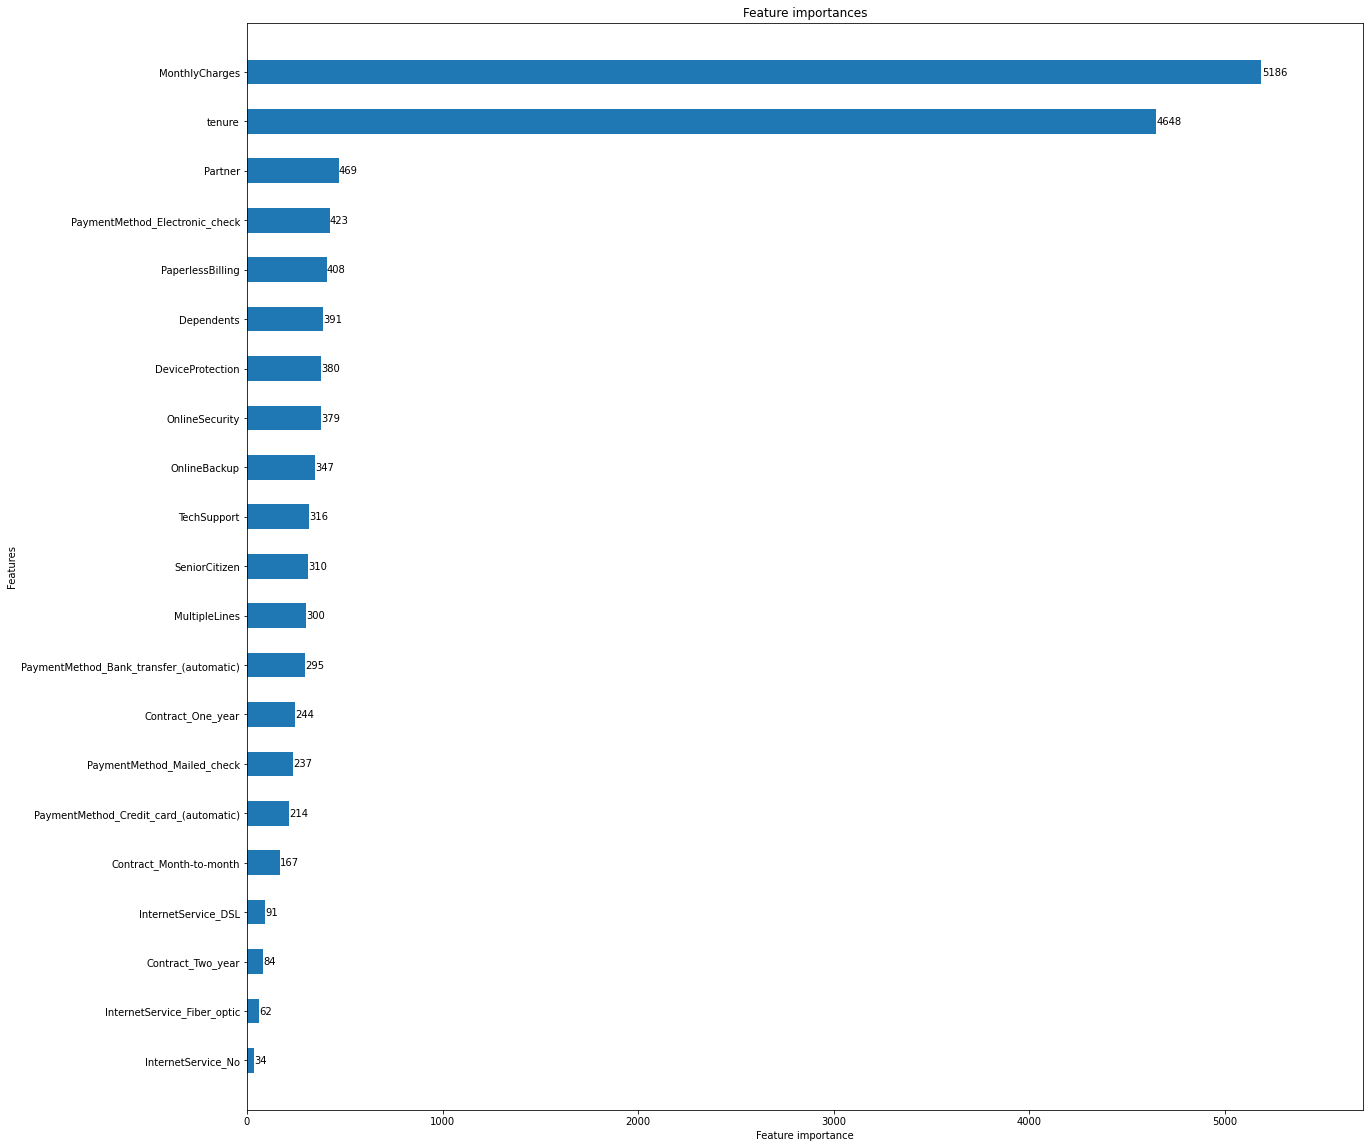

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
lightgbm.plot_importance(lgb,ax=ax,height=0.5,grid=False)
plt.title("Feature importances")
plt.show()

